In [1]:
from theano.sandbox import cuda

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 950 (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 5110)


In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [3]:
#path = "data/ml-20m/" # http://files.grouplens.org/datasets/movielens/ml-20m.zip
path = "data/ml-small/" # http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [4]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [7]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [8]:
pd.read_csv(path + 'movies.csv').set_index('movieId').head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [9]:
pd.read_csv(path + 'movies.csv').set_index('movieId')['title'].head()

movieId
1                      Toy Story (1995)
2                        Jumanji (1995)
3               Grumpier Old Men (1995)
4              Waiting to Exhale (1995)
5    Father of the Bride Part II (1995)
Name: title, dtype: object

In [10]:
users = ratings.userId.unique() #  ratings['userId'] also works. ratings.userId returns Series.
movies = ratings.movieId.unique()

In [12]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [13]:
ratings.movieId.head(3) # same as ratings.movieId[:3]

0      31
1    1029
2    1061
Name: movieId, dtype: int64

In [14]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [15]:
ratings.movieId.head(3) # movieId is converted to index number

0    0
1    1
2    2
Name: movieId, dtype: int64

In [16]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [17]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [18]:
n_factors = 50 # latent factor means 潜在因子 in Japanese.

In [19]:
np.random.seed = 42

Randomly split into training and validation.

In [20]:
msk = np.random.rand(len(ratings)) < 0.8 # (100004,)  list of True/False
trn = ratings[msk] # 80% goes to training
val = ratings[~msk] # 20% goes to validation

In [21]:
trn.head() # True data is only extracted

,userId,movieId,rating,timestamp
0,0,0,2.5,1260759144
1,0,1,3.0,1260759179
3,0,3,2.0,1260759185
5,0,5,2.0,1260759151
6,0,6,2.0,1260759187


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [22]:
# See http://www.mwsoft.jp/programming/numpy/sql_to_pandas.html  for good explanation groupby(), join()

g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [23]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [24]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId') # works like SQL inner join

In [25]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [26]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [27]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
# u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-6))(user_in) # http://forums.fast.ai/t/lesson-4-discussion/210/51
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
# m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-6))(movie_in)

In [28]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x) # receive two Inputs
model.compile(Adam(0.001), loss='mse')

In [29]:
print(trn.userId[:5])
print(trn.movieId[:5])
print(trn.rating[:5])

0    0
1    0
3    0
5    0
6    0
Name: userId, dtype: int64
0    0
1    1
3    3
5    5
6    6
Name: movieId, dtype: int64
0    2.5
1    3.0
3    2.0
5    2.0
6    2.0
Name: rating, dtype: float64


In [30]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80144 samples, validate on 19860 samples
Epoch 1/1
80144/80144 [==============================] - 2s - loss: 10.1607 - val_loss: 3.7997


In [31]:
model.optimizer.lr=0.01

In [32]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80144 samples, validate on 19860 samples
Epoch 1/3
80144/80144 [==============================] - 2s - loss: 2.2977 - val_loss: 1.7703
Epoch 2/3
80144/80144 [==============================] - 2s - loss: 1.2520 - val_loss: 1.4103
Epoch 3/3
80144/80144 [==============================] - 2s - loss: 0.9420 - val_loss: 1.2928


In [33]:
model.optimizer.lr=0.001

In [34]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80144 samples, validate on 19860 samples
Epoch 1/6
80144/80144 [==============================] - 2s - loss: 0.7919 - val_loss: 1.2399
Epoch 2/6
80144/80144 [==============================] - 2s - loss: 0.6994 - val_loss: 1.2277
Epoch 3/6
80144/80144 [==============================] - 2s - loss: 0.6338 - val_loss: 1.2215
Epoch 4/6
80144/80144 [==============================] - 2s - loss: 0.5801 - val_loss: 1.2194
Epoch 5/6
80144/80144 [==============================] - 2s - loss: 0.5325 - val_loss: 1.2243
Epoch 6/6
80144/80144 [==============================] - 2s - loss: 0.4882 - val_loss: 1.2293


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [35]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [36]:
# user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-6) # http://forums.fast.ai/t/lesson-4-discussion/210/51
# movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-6)

In [37]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp) # represent n_in size data in (1,) vector
    return Flatten()(x)

In [38]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [39]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [40]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

In [41]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80144 samples, validate on 19860 samples
Epoch 1/1
80144/80144 [==============================] - 3s - loss: 9.0971 - val_loss: 3.1400


In [42]:
model.optimizer.lr=0.01

In [43]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80144 samples, validate on 19860 samples
Epoch 1/6
80144/80144 [==============================] - 3s - loss: 1.8819 - val_loss: 1.4437
Epoch 2/6
80144/80144 [==============================] - 3s - loss: 1.0563 - val_loss: 1.1744
Epoch 3/6
80144/80144 [==============================] - 3s - loss: 0.8366 - val_loss: 1.0894
Epoch 4/6
80144/80144 [==============================] - 3s - loss: 0.7288 - val_loss: 1.0531
Epoch 5/6
80144/80144 [==============================] - 3s - loss: 0.6531 - val_loss: 1.0396
Epoch 6/6
80144/80144 [==============================] - 3s - loss: 0.5900 - val_loss: 1.0351


In [44]:
model.optimizer.lr=0.001

In [45]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80144 samples, validate on 19860 samples
Epoch 1/10
80144/80144 [==============================] - 3s - loss: 0.5343 - val_loss: 1.0407
Epoch 2/10
80144/80144 [==============================] - 3s - loss: 0.4820 - val_loss: 1.0473
Epoch 3/10
80144/80144 [==============================] - 3s - loss: 0.4320 - val_loss: 1.0485
Epoch 4/10
80144/80144 [==============================] - 3s - loss: 0.3835 - val_loss: 1.0596
Epoch 5/10
80144/80144 [==============================] - 3s - loss: 0.3376 - val_loss: 1.0654
Epoch 6/10
80144/80144 [==============================] - 3s - loss: 0.2944 - val_loss: 1.0743
Epoch 7/10
80144/80144 [==============================] - 3s - loss: 0.2558 - val_loss: 1.0875
Epoch 8/10
80144/80144 [==============================] - 3s - loss: 0.2215 - val_loss: 1.0963
Epoch 9/10
80144/80144 [==============================] - 3s - loss: 0.1924 - val_loss: 1.1099
Epoch 10/10
80144/80144 [==============================] - 3s - loss: 0.1677 - val_loss: 1.1227

In [46]:
# Looks result is worse than Jeremy's 0.79...
# Related topics
#     http://forums.fast.ai/t/lesson-4-discussion/210/56
#     http://forums.fast.ai/t/lesson-4-discussion/210/66
    
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80144 samples, validate on 19860 samples
Epoch 1/5
80144/80144 [==============================] - 3s - loss: 0.1472 - val_loss: 1.1377
Epoch 2/5
80144/80144 [==============================] - 3s - loss: 0.1305 - val_loss: 1.1508
Epoch 3/5
80144/80144 [==============================] - 3s - loss: 0.1166 - val_loss: 1.1612
Epoch 4/5
80144/80144 [==============================] - 3s - loss: 0.1056 - val_loss: 1.1743
Epoch 5/5
80144/80144 [==============================] - 3s - loss: 0.0961 - val_loss: 1.1885


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [47]:
model.save_weights(model_path+'bias.h5')

In [41]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [48]:
model.predict([np.array([3]), np.array([6])])

# When you want to use a new user or new movie, you should be aware of 'cold-start problem'.
# http://forums.fast.ai/t/lesson-4-discussion/210/21

array([[ 4.8658]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [49]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [50]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies) # predict bias
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)] # bias and movie name

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [51]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.065917894, 'Hannibal (2001)'),
 (-0.061756939, 'Legally Blonde (2001)'),
 (-0.051715724, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (-0.050530974, 'Splash (1984)'),
 (-0.044573087, "Pete's Dragon (1977)"),
 (-0.042329319, 'Brokeback Mountain (2005)'),
 (-0.035824824, 'Super Mario Bros. (1993)'),
 (-0.021988017, 'Deep Blue Sea (1999)'),
 (-0.021837996, '101 Dalmatians (1996)'),
 (-0.015359756, 'Sweet Home Alabama (2002)'),
 (-0.0096944654, 'Bulworth (1998)'),
 (-0.009430686, 'I Know What You Did Last Summer (1997)'),
 (-0.0087585589, 'Big Fish (2003)'),
 (-0.0048287935, 'Battlefield Earth (2000)'),
 (-0.0039288942, 'Escape from L.A. (1996)')]

In [52]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(0.61903059, 'Shawshank Redemption, The (1994)'),
 (0.58555442, 'Godfather, The (1972)'),
 (0.58054113, 'Silence of the Lambs, The (1991)'),
 (0.5327217, 'Fugitive, The (1993)'),
 (0.49948153, 'Fargo (1996)'),
 (0.48569348, "Schindler's List (1993)"),
 (0.46900132, 'Forrest Gump (1994)'),
 (0.46119881, 'Matrix, The (1999)'),
 (0.44262955, 'Heat (1995)'),
 (0.44082594, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.43181065, 'Stargate (1994)'),
 (0.4256056, 'Apollo 13 (1995)'),
 (0.40634707, 'Usual Suspects, The (1995)'),
 (0.40256995, 'Patriot Games (1992)'),
 (0.40151921, 'American Beauty (1999)')]

We can now do the same thing for the embeddings.

In [53]:
get_movie_emb = Model(movie_in, m) # input: movie_in, output: m (embedding vector)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies])) # (2000, 1, 50) -> (2000, 50)
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [54]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_ # We want to get components matrix (n_components, original dimension)

In [55]:
fac0 = movie_pca[0] # movie_pac=(3, 2000), fac0=(2000,) 

In [56]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [57]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(-0.0053885188249114657, 'Battlefield Earth (2000)'),
 (-0.0054957789590380432, 'Blade: Trinity (2004)'),
 (-0.0077952170147241508, 'Jaws 3-D (1983)'),
 (-0.0078116764254715504, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.0080252779629099609, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.0080504170122159581, 'Grease 2 (1982)'),
 (-0.0086555322702652707, 'King Kong (1976)'),
 (-0.0092005142747956879, 'Bonfire of the Vanities (1990)'),
 (-0.0093406535546395417, 'House on Haunted Hill (1999)'),
 (-0.0094367284118839455, 'Children of the Corn (1984)')]

In [58]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.031755306823124482, 'Empire of the Sun (1987)'),
 (-0.031212116296917579, 'Philadelphia Story, The (1940)'),
 (-0.030731512609072302,
  'Wings of Desire (Himmel \xc3\xbcber Berlin, Der) (1987)'),
 (-0.030552738738244437, 'Blue in the Face (1995)'),
 (-0.030441341491226178, 'It Happened One Night (1934)'),
 (-0.030137520536827025, 'Shadowlands (1993)'),
 (-0.03005923205971666, "Nobody's Fool (1994)"),
 (-0.03000402175385148, 'Name of the Rose, The (Name der Rose, Der) (1986)'),
 (-0.029713721039843995, 'Smoke (1995)'),
 (-0.029703665697054956, 'Happiness (1998)')]

In [59]:
fac1 = movie_pca[1]

In [60]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [61]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.077320086325183515, 'Down Periscope (1996)'),
 (0.062531102786696283, 'Patch Adams (1998)'),
 (0.062234757077845371, 'Passion of the Christ, The (2004)'),
 (0.061965160421580477, 'Armageddon (1998)'),
 (0.06011444740343351, 'Police Academy 4: Citizens on Patrol (1987)'),
 (0.059398918455410996, 'Jack (1996)'),
 (0.059376313620784764, '2012 (2009)'),
 (0.058372504231149723, 'RoboCop 3 (1993)'),
 (0.056368401838738771, 'Bio-Dome (1996)'),
 (0.055960316101533708, 'Gone in 60 Seconds (2000)')]

In [62]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.067751373035061221, 'Brokeback Mountain (2005)'),
 (-0.06293446510925392, 'General, The (1926)'),
 (-0.06120810992220261, 'Midnight Cowboy (1969)'),
 (-0.060413482929793906, 'Bringing Up Baby (1938)'),
 (-0.057966784139862386, 'Thin Man, The (1934)'),
 (-0.057754069952779333, 'City Lights (1931)'),
 (-0.057717417305790261, 'Harold and Maude (1971)'),
 (-0.054802597245764278, 'Purple Rose of Cairo, The (1985)'),
 (-0.054050177876383297, 'Little Big Man (1970)'),
 (-0.054016105474784637, 'Vertigo (1958)')]

In [63]:
fac2 = movie_pca[2]

In [64]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [65]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.067145483344664525, 'Death and the Maiden (1994)'),
 (0.064161099645141356, 'James and the Giant Peach (1996)'),
 (0.063417034565575445, 'Daylight (1996)'),
 (0.062766785539992501, 'Wyatt Earp (1994)'),
 (0.06185015437881991, 'Star Trek IV: The Voyage Home (1986)'),
 (0.060648176283666644, 'City Hall (1996)'),
 (0.059899897924706534, 'Copycat (1995)'),
 (0.059287476147764917, 'Midnight in the Garden of Good and Evil (1997)'),
 (0.059172523357613832, "Miller's Crossing (1990)"),
 (0.058637212873614571, 'Barb Wire (1996)')]

In [66]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.083623625171381472, 'American Psycho (2000)'),
 (-0.074148619810881972, 'Inside Out (2015)'),
 (-0.074023844260411378, 'Black Swan (2010)'),
 (-0.067972974199962191, 'Deadpool (2016)'),
 (-0.065989498866715207, 'The Imitation Game (2014)'),
 (-0.061362007265759418, 'Pineapple Express (2008)'),
 (-0.060732722288667704, 'K-PAX (2001)'),
 (-0.060288800379707429, 'Da Vinci Code, The (2006)'),
 (-0.05985271271413032, 'Road Warrior, The (Mad Max 2) (1981)'),
 (-0.059750784540849471, 'Lost in Translation (2003)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [67]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

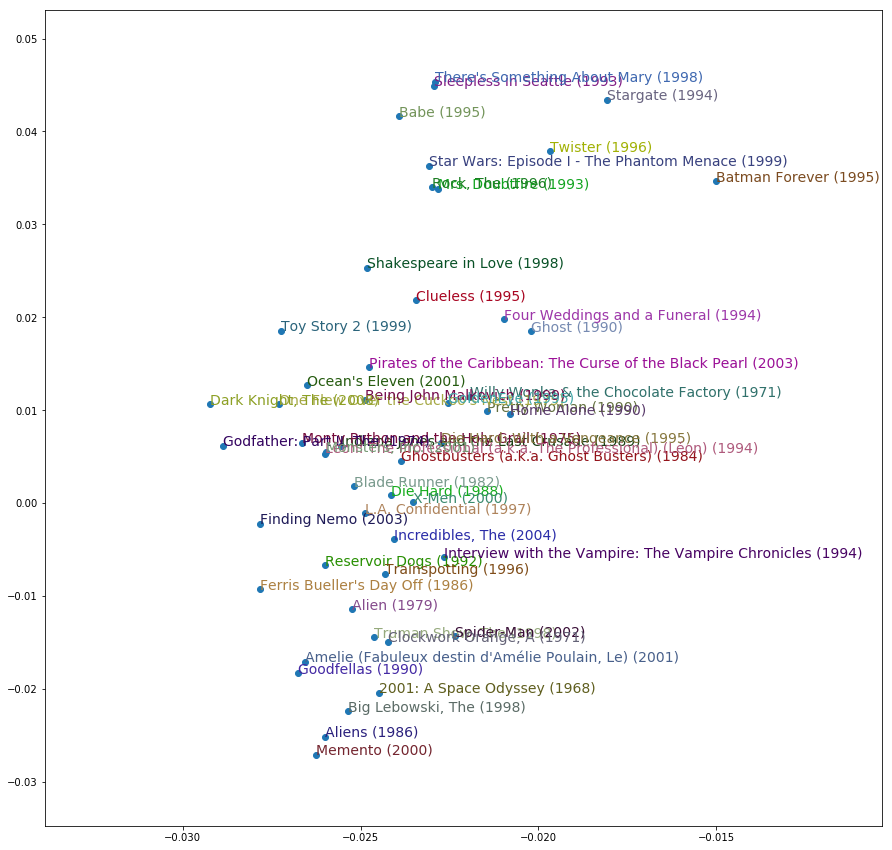

In [68]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [69]:
#user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
#movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-6) # http://forums.fast.ai/t/lesson-4-discussion/210/51
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-6)

In [70]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [71]:
nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_7 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_8 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

In [72]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80144 samples, validate on 19860 samples
Epoch 1/8
80144/80144 [==============================] - 3s - loss: 2.4788 - val_loss: 0.9384
Epoch 2/8
80144/80144 [==============================] - 3s - loss: 1.4508 - val_loss: 0.8598
Epoch 3/8
80144/80144 [==============================] - 3s - loss: 1.1890 - val_loss: 0.8439
Epoch 4/8
80144/80144 [==============================] - 3s - loss: 0.9817 - val_loss: 0.8233
Epoch 5/8
80144/80144 [==============================] - 3s - loss: 0.8427 - val_loss: 0.7989
Epoch 6/8
80144/80144 [==============================] - 3s - loss: 0.7732 - val_loss: 0.7967
Epoch 7/8
80144/80144 [==============================] - 3s - loss: 0.7410 - val_loss: 0.7951
Epoch 8/8
80144/80144 [==============================] - 3s - loss: 0.7269 - val_loss: 0.7899


This improves on our already impressive accuracy even further!